In [1]:
import glob, matplotlib, re, math, pandas, sys, argparse
import numpy as np
from sklearn.preprocessing import MinMaxScaler
from models import autoencoder
import torch
randomSeed = 5
torch.manual_seed(randomSeed)
import random
random.seed(randomSeed)
np.random.seed(randomSeed)
from torch import nn
from torch.autograd import Variable

%matplotlib inline
import matplotlib.pyplot as plt
plt.style.use('default')
font = {'size':14}
matplotlib.rc('font', **font)

In [35]:
#from data import get_DataLoaders
from data_ttMET_delphes import get_DataLoaders
args = argparse.Namespace()
#args.data = '/users/whopkins/sigclustering/sigclustering/ccMET_noBackground.h5'
args.data = '/users/whopkins/sigclustering/sigclustering/python/ttMET_delphes_sepSigs.h5'
args.time_throughput = False
args.batch_size = 128
#trainBranches = ['MTcMin20', 'metsigST', 'pT_1jet', 'pT_2jet', 'nj_good', 'num_cjets20']#, 'm_cc20', ]
#trainBranches = ['MTbmin', 'MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets']
trainBranches = ['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good', 'num_bjets', 'pT_1bjet', 'pT_2bjet', 'eta_1jet', 'eta_2jet']#, 'eta_3jet', 'eta_4jet']
varListStr = '_'.join(trainBranches)
signals = []#['sig_1300_1', 'sig_700_400', 'sig_500_1']
#trainDataLoader, testDataLoader, allData, scaledData, selectedSigs = get_DataLoaders(args, trainBranches, signals=signals, minSize=100, preselStr="presel_ML_1cjet")
trainDataLoader, testDataLoader, allData, scaledData, selectedSigs = get_DataLoaders(args, trainBranches, signals=signals, minSize=1000)

No preselection specified


Number of signal samples: 298


Dropping sig_200_1 with size 234
Dropping sig_200_100 with size 468


Dropping sig_200_50 with size 309
Dropping sig_250_1 with size 602


Dropping sig_250_100 with size 594
Dropping sig_250_150 with size 852


Dropping sig_250_50 with size 498


Dropping sig_300_100 with size 945


Total number of events to be clustered: 7326697


We will make all samples have the following raw event yield: 1131


aeData.shape: (327990, 12)
aeData.columns: Index(['MET', 'HT', 'pT_1jet', 'pT_2jet', 'pT_3jet', 'pT_4jet', 'nj_good',
       'num_bjets', 'pT_1bjet', 'pT_2bjet', 'eta_1jet', 'eta_2jet'],
      dtype='object')
tempWeights.shape: (327990, 91)
samples: ['sig_1000_1', 'sig_1000_100', 'sig_1000_150', 'sig_1000_200', 'sig_1000_250', 'sig_1000_300', 'sig_1000_350', 'sig_1000_400', 'sig_1000_450', 'sig_1000_50', 'sig_1000_500', 'sig_1000_550', 'sig_1000_600', 'sig_1000_650', 'sig_1050_1', 'sig_1050_100', 'sig_1050_150', 'sig_1050_200', 'sig_1050_250', 'sig_1050_300', 'sig_1050_350', 'sig_1050_400', 'sig_1050_450', 'sig_1050_50', 'sig_1050_500', 'sig_1050_550', 'sig_1050_600', 'sig_1050_650', 'sig_1100_1', 'sig_1100_100', 'sig_1100_150', 'sig_1100_200', 'sig_1100_250', 'sig_1100_300', 'sig_1100_350', 'sig_1100_400', 'sig_1100_450', 'sig_1100_50', 'sig_1100_500', 'sig_1100_550', 'sig_1100_600', 'sig_1100_650', 'sig_1150_1', 'sig_1150_100', 'sig_1150_150', 'sig_1150_200', 'sig_1150_250', 'sig_115

_allSignals
MET 250.0 2547.0
HT 54.109375 4816.0
pT_1jet 23.32308 2979.877
pT_2jet 22.863684 2149.8005
pT_3jet -9999.0 1709.8102
pT_4jet -9999.0 1686.1969


nj_good 2 16
num_bjets 0 7
pT_1bjet -9999.0 2489.7485
pT_2bjet -9999.0 1813.019


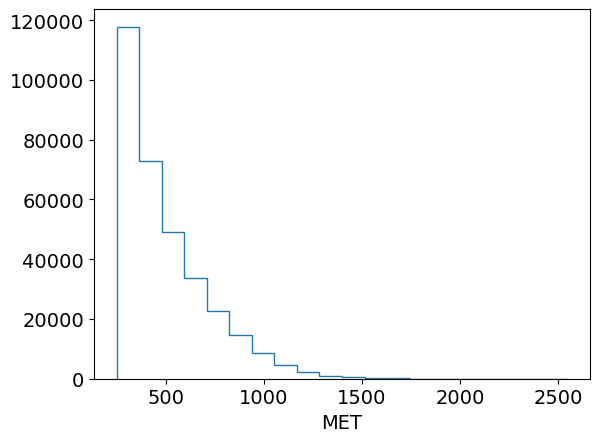

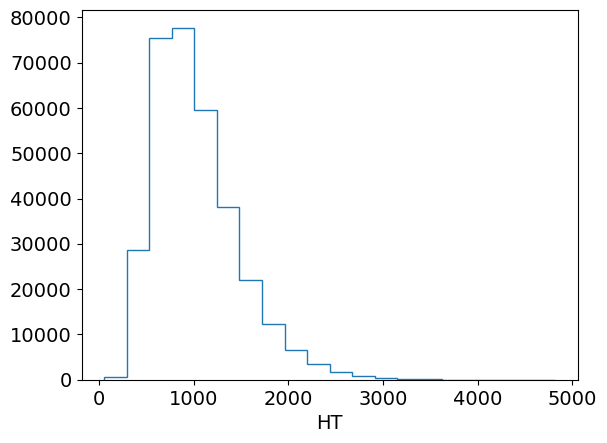

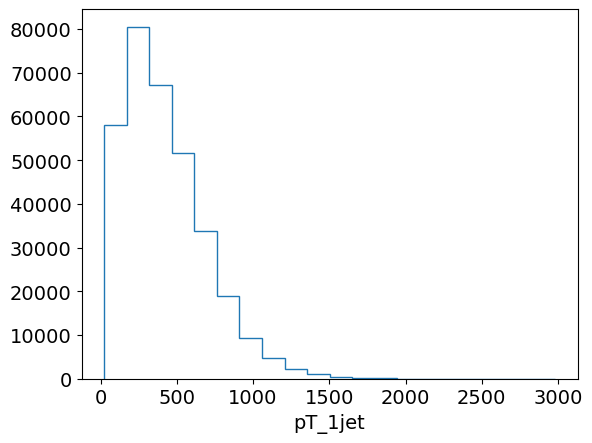

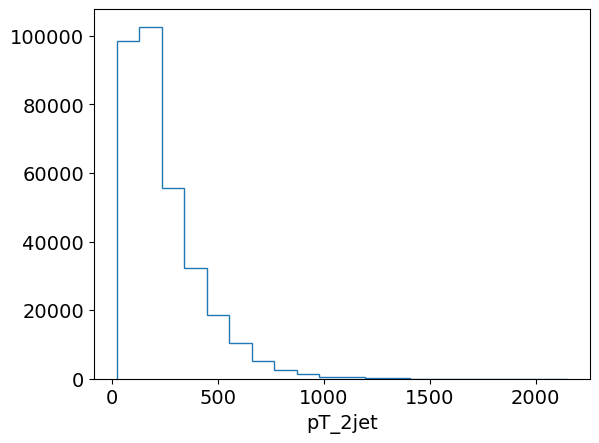

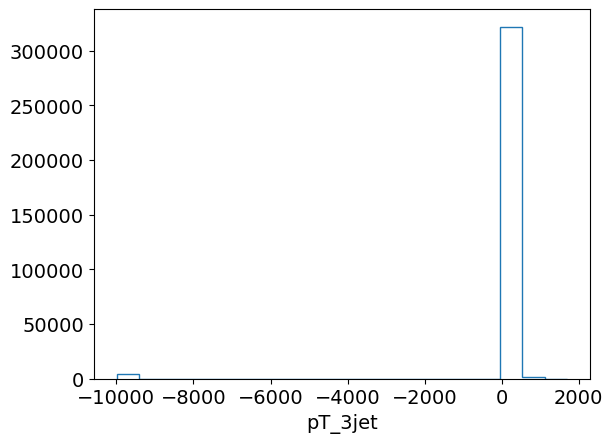

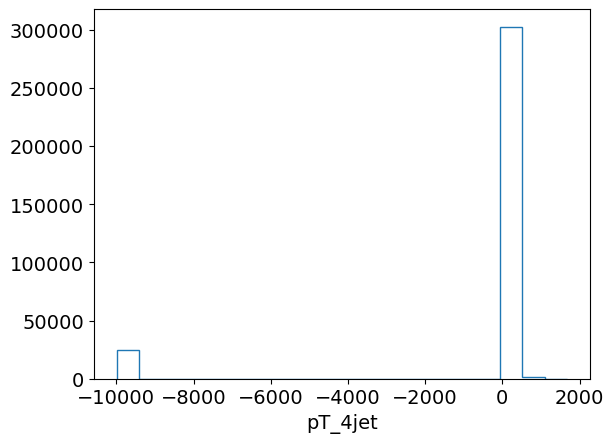

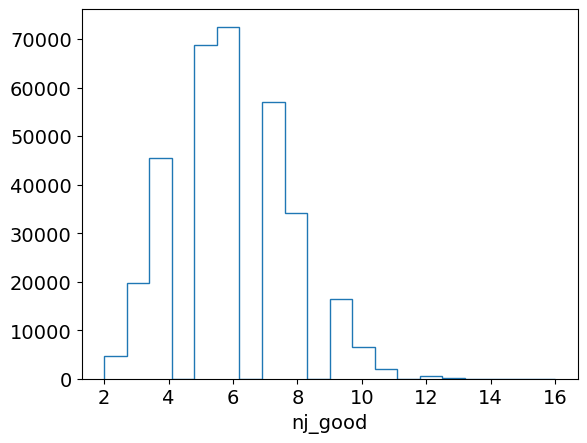

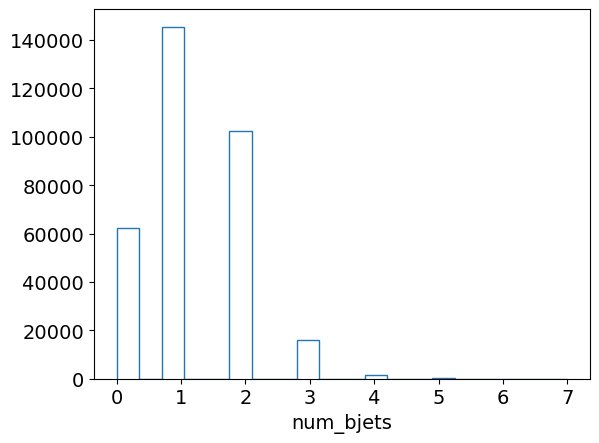

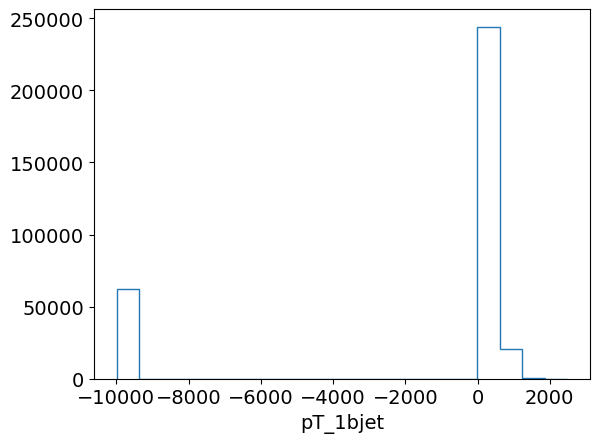

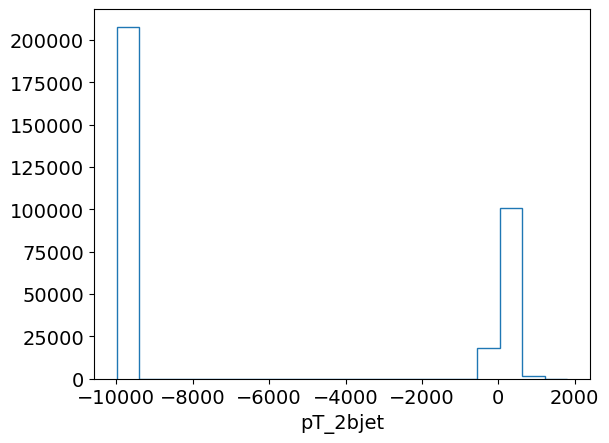

In [17]:
# Let's plot the input variables to make sure we don't have some ugly spikes
sigStr = '__'.join(signals)
sigStr = '_'+sigStr

if signals == []:
    sigStr = '_allSignals'
print(sigStr)
nBins = 20
for branch in trainBranches:
    fig, ax = plt.subplots()
    plotData = selectedSigs[branch]
    xMin = np.min(plotData.to_numpy(), axis=0)
    xMax = np.max(plotData.to_numpy(), axis=0)
    print(branch, xMin, xMax)
    dX = (xMax-xMin)/nBins
    bins = [xMin+i*dX for i in range(nBins+1)]
    a = plt.hist(plotData, histtype='step', bins=bins)
    ax.set_xlabel(branch)
    # plt.savefig(f'{branch}{sigStr}.pdf', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.svg', bbox_inches='tight')
    # plt.savefig(f'{branch}{sigStr}.png', bbox_inches='tight')

autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=10, out_features=8, bias=True)
    (1): ReLU()
    (2): Linear(in_features=8, out_features=6, bias=True)
    (3): ReLU()
    (4): Linear(in_features=6, out_features=4, bias=True)
    (5): ReLU()
    (6): Linear(in_features=4, out_features=2, bias=True)
    (7): ReLU()
    (8): Linear(in_features=2, out_features=1, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=1, out_features=2, bias=True)
    (1): ReLU()
    (2): Linear(in_features=2, out_features=4, bias=True)
    (3): ReLU()
    (4): Linear(in_features=4, out_features=6, bias=True)
    (5): ReLU()
    (6): Linear(in_features=6, out_features=8, bias=True)
    (7): ReLU()
    (8): Linear(in_features=8, out_features=10, bias=True)
  )
  (criterion): MSELoss()
)


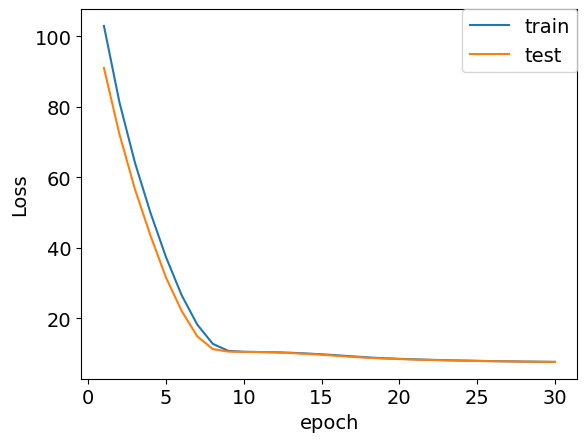

In [30]:
latent_dim = 1
learning_rate = 1e-5

torch.cuda.empty_cache()
num_epochs = 30
model = autoencoder(len(trainBranches), latent_dim, reduction=2, sigmoidDecoderOut=False, sigmoidEncoderOut=False)
print(model)
if torch.cuda.is_available():
    model = model.cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

history = {'loss':[[],[]], 'val_loss':[[],[]]}
verbose = False

for epoch in range(num_epochs):
    total_loss = 0
    model.train()
    for data, labels, weights in trainDataLoader:
    #for data, labels in trainDataLoader:
        if torch.cuda.is_available():
            #data, labels, weights = data.cuda(), labels.cuda(), weights.cuda()
            data, labels = data.cuda(), labels.cuda()
        # ===================forward=====================
        
        #train_loss, output = model(data,labels,weights)
        train_loss, output = model(data,labels)
        #print(output)
        # labels is the same as data for an autoencoder but we may as well keep
        # things the same as a normal NN. The weights are useful for grouping background
        # into one class (even though it consists of W+jets, Z+jets, etc).
        #train_loss = (train_loss*trainWeights).mean()
        #train_loss = criterion(output, labels)
        # ===================backward====================
        optimizer.zero_grad()
        train_loss.backward()
        optimizer.step()
        total_loss+=train_loss.item()
    # ===================log========================
    num_batches = len(trainDataLoader)
    history['loss'][0].append(epoch+1)
    history['loss'][1].append(total_loss/num_batches)

    total_val_loss = 0
    model.eval()
    for data, labels, weights in testDataLoader:
    #for data, labels in testDataLoader:
        if torch.cuda.is_available():
            #data, labels, weights = data.cuda(), labels.cuda(), weights.cuda()
            data, labels = data.cuda(), labels.cuda()
        
        with torch.no_grad():
            #val_loss, output = model(data,labels, weights)
            val_loss, output = model(data,labels)
            #val_loss = (val_loss*testWeights).mean()
            #val_loss = criterion(output,labels)
            total_val_loss += val_loss.item()
    num_batches = len(testDataLoader)
    history['val_loss'][0].append(epoch+1)
    history['val_loss'][1].append(total_val_loss/num_batches)

    if verbose:
        print('epoch [{}/{}], train loss: {:.4f}, test loss:{:.4f}'
              .format(epoch + 1, num_epochs, loss.item(), val_loss.item()))
a = model.eval()
fig, ax = plt.subplots()
plt.plot(history['loss'][0], history['loss'][1])
plt.plot(history['val_loss'][0], history['val_loss'][1])
ax.set_xlabel('epoch')
ax.set_ylabel('Loss')
leg = plt.legend(['train', 'test'], loc=0, borderaxespad=0.)
plt.savefig(f'loss{sigStr}_latentDim{latent_dim}.pdf', bbox_inches='tight')

In [31]:
torch.save(model.state_dict(), f'model{sigStr}_latentDim{latent_dim}.pkl')

In [32]:
encoded = []
decoded = []
#print(output)
encodedColumns = [f'latent{i}' for i in range(1, latent_dim+1)]
for sampName in sorted(pandas.unique(scaledData.sampName)):
    tempData = torch.Tensor(scaledData[scaledData.sampName==sampName][trainBranches].to_numpy())
    if torch.cuda.is_available():
            tempData = tempData.cuda()
    encodedData = model.encoder(tempData)
    
    decodedData = model.decoder(encodedData).cpu().detach().numpy()
    tempDF = pandas.DataFrame(encodedData.cpu().detach().numpy(), columns=encodedColumns)
    tempDF['sampName'] = sampName
    encoded.append(tempDF)
    tempDF = pandas.DataFrame(decodedData, columns=trainBranches)
    tempDF['sampName'] = sampName
    decoded.append(tempDF)

allEncoded = pandas.concat(encoded)
allDecoded = pandas.concat(decoded)
# Now save the encoder data to be used for clustering later
allEncoded.to_hdf(f'encodedData{sigStr}_latentDim{latent_dim}.h5', key='encoded', mode='w')

-3.4669733 -0.54559255 0.09737935860951742


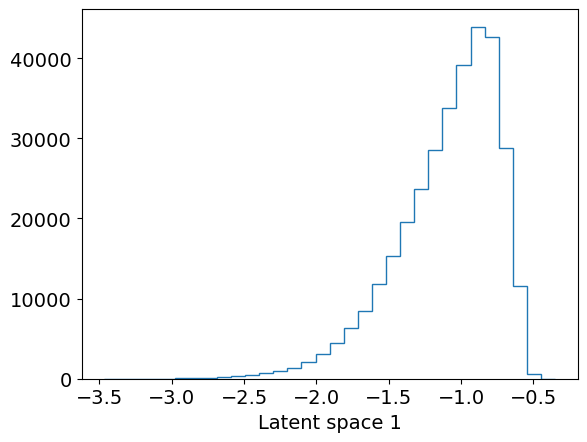

In [38]:
# This shows the latent spacce distributions for the two signals. Essentially we have trained a unsupervised
# classifier since labels were not given to the NN. The latent space is overly simple here (1D).
# We can applying clustering to this latent space and avoid high dimensionality and essentially
# summarize low-level variables. A variational auto-encoder would make these nice Gaussians at which point
# we may be able to use model-based clustering (k-means will also work).
fig, ax = plt.subplots()
totalEncodedDist = allEncoded.drop('sampName', axis=1)
nBins = 30
if totalEncodedDist.shape[1] == 2:
    xMin, yMin = np.min(totalEncodedDist, axis=0)
    xMax, yMax = np.max(totalEncodedDist, axis=0)
    dX = (xMax-xMin)/nBins
    dY = (yMax-yMin)/nBins
    print(xMin, xMax, dX, yMin, yMax, dY)
    bins2d = [[xMin+i*dX for i in range(nBins+2)], [yMin+i*dY for i in range(nBins+2)]]
    a = plt.hist2d(totalEncodedDist.latent1, totalEncodedDist.latent2, bins=bins2d,)
    ax.set_ylabel('Latent space 2')
elif totalEncodedDist.shape[1] == 1:
    xMin = np.min(totalEncodedDist.to_numpy(), axis=0)[0]
    xMax = np.max(totalEncodedDist.to_numpy(), axis=0)[0]
    dX = (xMax-xMin)/nBins
    print(xMin, xMax, dX)
    bins = [xMin+i*dX for i in range(nBins+3)]
    a = plt.hist(totalEncodedDist.latent1, histtype='step', bins=bins)
ax.set_xlabel('Latent space 1')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.pdf', bbox_inches='tight')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.svg', bbox_inches='tight')
plt.savefig(f'latentSpace{sigStr}_latentDim{latent_dim}.png', bbox_inches='tight')

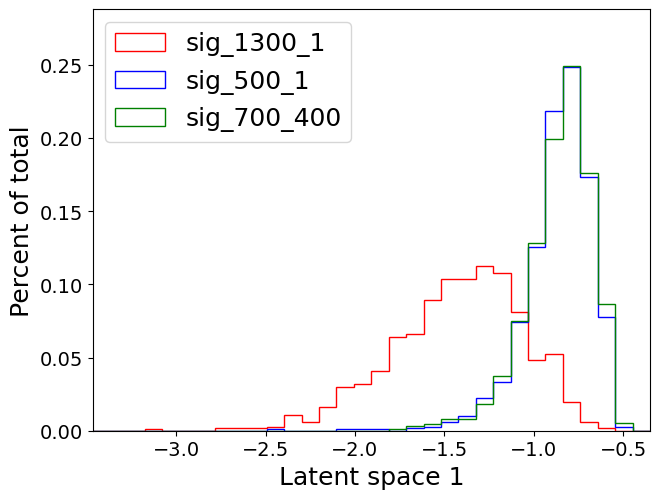

In [42]:
colorMaps = [plt.cm.Reds, plt.cm.Blues, plt.cm.Greys]
colors = ['r', 'b', 'g']
markerstyles=['.' for c in colors]
custom_lines = [Line2D([0], [0], color=color, lw=2) for color in colors]
import matplotlib.patches as mpatches
import matplotlib.lines as mlines
fontsize=8
plotSamps = ['sig_1300_1', 'sig_500_1', 'sig_700_400']
fontsize=18
fig, ax = plt.subplots()
for color, cmap, sampLabel in zip(colors, colorMaps, plotSamps):
    legHandles = [mpatches.Patch(color=color, label=sampLabel)]
    plotDist = allEncoded[allEncoded.sampName==sampLabel].drop('sampName', axis=1)
    if plotDist.shape[1] == 2:
        fig, ax = plt.subplots()
        plt.hist2d(plotDist.latent1, plotDist.latent2, bins=bins2d, cmap=cmap, label=sampLabel)#, weights=sampData.weight)
        ax.set_xlabel('Latent space 1', fontsize=fontsize)
        ax.set_ylabel('Latent space 2', fontsize=fontsize)
        ax.set_xlabel('Latent space 1', fontsize=fontsize)
        ax.legend(ncol=1, handles=legHandles, fontsize=fontsize, loc=0)
        plt.tight_layout(pad=0.0)
        plt.margins(0,0)
        
        plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.svg",bbox_inches='tight', pad_inches=0)
        plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.pdf",bbox_inches='tight', pad_inches=0)
    elif plotDist.shape[1] == 1:
        plt.hist(plotDist.latent1, histtype='step', bins=bins, color=color, label=sampLabel, weights=np.ones(plotDist.latent1.shape)/plotDist.latent1.shape[0])
    
if plotDist.shape[1] == 1:
    ax.set_xlabel('Latent space 1', fontsize=fontsize)
    ax.set_ylabel('Percent of total', fontsize=fontsize)
    ax.legend(ncol=1, fontsize=fontsize, loc=2)
    ax.set_ylim([0, ax.get_ylim()[1]*1.1])
    plt.tight_layout(pad=0.0)
    plt.margins(0,0)
    plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.svg",bbox_inches='tight', pad_inches=0)
    plt.savefig(f"latentSpace_{sampLabel}{sigStr}_{latent_dim}DHist.pdf",bbox_inches='tight', pad_inches=0)  